In [1]:
## ATSA ROUTINE v.2 ##

#---------------------User Input-------------------------#
sig_levels = [0.01,0.05,0.1]
Remove_Hawaii = False
#--------------------------------------------------------#


#----------------------Packages--------------------------#
from global_land_mask import globe
import pandas as pd
import numpy as np
from scipy import stats as stat
import pickle
import os

def extract(group, i):
    return list(elem[i] for elem in group)
#--------------------------------------------------------#


#--------------------From Model 1------------------------#
ref_guide_path = '/n/home06/acrawford/mcb_data/sst_files/'
reffile = 'model_1_ref_guide.csv'
#--------------------------------------------------------#


#--------------------From Model 2------------------------#
with open(ref_guide_path+'model_2b_advection_data.txt','rb') as file:
    mod_data = pickle.load(file)
with open(ref_guide_path+'model_2b_advection_start.txt','rb') as file:
    ncase_start = int(pickle.load(file))-1
#--------------------------------------------------------#


In [2]:
## Statistical Analysis ##

#Clean Old Data
os.system('cd {0} && rm ATSA_*'.format(ref_guide_path))

#Mask Hawaii
if Remove_Hawaii == True: Hawaii = 220
else: Hawaii = -np.inf

#Calculate Strikepoints for All Cases in Trial
strikepoints = []
for ntrack in range(len(mod_data[0])):
    ncase = ncase_start
    for case2 in mod_data:
        ncase += 1
        for point in case2[ntrack]:
            if point[2] >= 180: lon_mask = point[2]-360
            else: lon_mask = point[2]
            if globe.is_land(point[1],lon_mask) == True and point[2] >= Hawaii:
                strikepoints.append([ncase,point[0],point[1],point[2]])
                break
            elif point[0] == 336: strikepoints.append([ncase,point[0],point[1],point[2]])

assert ncase > ncase_start+1,'There Must be More Than One Case in the Study'
                
#Determine Trial Configuration
rguide = pd.read_csv(ref_guide_path+reffile,
                    header=0,index_col=1)
rguide = pd.DataFrame.drop(rguide,'Unnamed: 0',axis=1)

CR_app = []
for col in rguide.columns:
    CR = rguide[col]
    ON = list(map(int,CR.index[CR == 1].tolist()))
    OFF = list(map(int,CR.index[CR == 0].tolist()))
    CR_app.append([ON,OFF])

#Prepare Lists for Significance Testing
sig_tests = []
for CR2 in CR_app:
    sig_track = []
    for ntrack2 in range(len(mod_data[0])):
        on_temp = []
        off_temp = []
        for ncase2 in range(len(mod_data)):
            TC = strikepoints[ncase*ntrack2+ncase2]
            if TC[0] in CR2[0]: on_temp.append([TC[1],TC[2],TC[3]])
            if TC[0] in CR2[1]: off_temp.append([TC[1],TC[2],TC[3]])
        sig_track.append([on_temp,off_temp]) 
    sig_tests.append(sig_track)
    
#Perform Significance Tests
welsh_results = pd.DataFrame(columns=['Region','Track','Time','Latitude','Longitude'])
region_count = 1
for region in sig_tests:
    track_count = 1
    for track in region:
        t_result_t = stat.ttest_ind(extract(track[0],0),extract(track[1],0),equal_var=False)[1]
        t_result_lat = stat.ttest_ind(extract(track[0],1),extract(track[1],1),equal_var=False)[1]
        t_result_lon = stat.ttest_ind(extract(track[0],2),extract(track[1],2),equal_var=False)[1]
        welsh_results = welsh_results.append({'Region':region_count,'Track':track_count,
                                              'Time':t_result_t,'Latitude':t_result_lat,
                                              'Longitude':t_result_lon},ignore_index=True)
        track_count += 1
    region_count +=1

#Write Outcome Data
welsh_results = welsh_results.fillna(1)
welsh_results.to_csv(ref_guide_path+'ATSA_WelshR_{0}-{1}.csv'.format(ncase_start+1,ncase),index=False)
region_results = welsh_results.groupby('Region').mean()
region_results = pd.DataFrame.drop(region_results,'Track',axis=1)
region_results.to_csv(ref_guide_path+'ATSA_RegR_{0}-{1}.csv'.format(ncase_start+1,ncase),index=False)

for sig_level in sig_levels:
    
    sig_results = welsh_results.drop(welsh_results[(welsh_results['Time'] >= sig_level)
                                                   & (welsh_results['Latitude'] >= sig_level)
                                                   & (welsh_results['Longitude'] >= sig_level)
                                                  ].index)
    sig_reg_results = region_results.drop(region_results[(region_results['Time'] >= sig_level)
                                                   & (region_results['Latitude'] >= sig_level)
                                                   & (region_results['Longitude'] >= sig_level)
                                                  ].index)
    sig_results.to_csv(ref_guide_path+'ATSA_SigR_{0}-{1}_alpha={2:.2f}.csv'.format(
        ncase_start+1,ncase,sig_level),index=False)
    sig_reg_results.to_csv(ref_guide_path+'ATSA_RegSigR_{0}-{1}_alpha={2:.2f}.csv'.format(
        ncase_start+1,ncase,sig_level),index=False)
    

In [3]:
## Preliminary Data Visualization ##

print('t-test Results for All TC Tracks for Cases {0}-{1}:\n'.format(ncase_start+1,ncase))
print(welsh_results)
print('\n\n t-test Results Aggregated by Cooling Region for Cases {0}-{1}:\n'.format(ncase_start+1,ncase))
print(region_results)


t-test Results for All TC Tracks for Cases 1-512:

     Region  Track           Time       Latitude      Longitude
0       1.0    1.0   3.182585e-01   4.604844e-03   6.384883e-68
1       1.0    2.0   1.000000e+00   1.281949e-18   9.903240e-63
2       1.0    3.0   5.239472e-01   3.377084e-12   4.162998e-01
3       1.0    4.0  8.147901e-105   1.128266e-54   5.700483e-72
4       1.0    5.0   6.949349e-49  2.948574e-144  2.154387e-105
..      ...    ...            ...            ...            ...
103     9.0    8.0   1.000000e+00   3.718143e-01   3.622292e-01
104     9.0    9.0   1.000000e+00   6.992845e-01   3.761950e-01
105     9.0   10.0   1.000000e+00   3.535603e-01   9.131883e-01
106     9.0   11.0   1.000000e+00   4.399391e-01   6.017352e-01
107     9.0   12.0   1.000000e+00   2.060323e-46   2.313917e-47

[108 rows x 5 columns]


 t-test Results Aggregated by Cooling Region for Cases 1-512:

            Time  Latitude  Longitude
Region                               
1.0     0.653517

Strikepoints for Tracks in Case 1:

Landfall (5,220) :  [ 9.465 , 131.550 ]  |  Time: 336 hrs
Landfall (5,230) :  [ 8.236 , 147.327 ]  |  Time: 336 hrs
Landfall (5,240) :  [ 3.974 , 163.992 ]  |  Time: 336 hrs
Landfall (5,250) :  [ -22.859 , 286.180 ]  |  Time: 336 hrs
Landfall (10,220) :  [ 18.706 , 155.026 ]  |  Time: 336 hrs
Landfall (10,230) :  [ 13.769 , 171.825 ]  |  Time: 336 hrs
Landfall (10,240) :  [ 10.559 , 175.058 ]  |  Time: 336 hrs
Landfall (10,250) :  [ 6.798 , 165.473 ]  |  Time: 336 hrs
Landfall (15,220) :  [ 21.014 , 203.418 ]  |  Time: 175 hrs
Landfall (15,230) :  [ 23.089 , 186.125 ]  |  Time: 336 hrs
Landfall (15,240) :  [ 23.853 , 208.693 ]  |  Time: 336 hrs
Landfall (15,250) :  [ 18.944 , 185.607 ]  |  Time: 336 hrs
Landfall (20,220) :  [ 18.955 , 176.350 ]  |  Time: 336 hrs
Landfall (20,230) :  [ 21.525 , 235.988 ]  |  Time: 336 hrs
Landfall (20,240) :  [ 23.995 , 184.994 ]  |  Time: 336 hrs
Landfall (20,250) :  [ 25.271 , 231.954 ]  |  Time: 336 hrs
Landfall (2

<Figure size 1080x648 with 0 Axes>

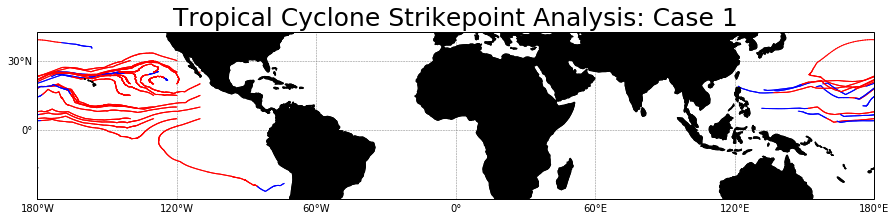

In [5]:
## Mapping Subroutine ##

#---------------------User Input-------------------------#
case = 1
#--------------------------------------------------------#


#----------------------Packages--------------------------#
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
import nc_time_axis
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.ticker as mticker
from global_land_mask import globe

def add_latlon_ticks(ax):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0.5, color='gray', linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylocator = mticker.FixedLocator(np.arange(-90,91,30))
#--------------------------------------------------------#

map_case = case-ncase_start
assert (map_case > 0 and map_case <= ncase),'Selected Case not Contained in Given Trial Range ({0}-{1})'.format(
    ncase_start+1,ncase)
print ('Strikepoints for Tracks in Case {0}:\n'.format(map_case))

fig = plt.figure(figsize=[15,9])
fig = plt.figure(figsize=[15,9])
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cft.LAND, zorder=100, edgecolor='white',color='black')
add_latlon_ticks(ax)

def advec_track(track,color):
    for step in range(len(track)-1):
        if step >= len(track)-51: color = 'blue'
        plt.plot([track[step][2],track[step+1][2]],[track[step][1],track[step+1][1]], 
                 color=color, linewidth=1, transform=ccrs.PlateCarree(),)
        if track[step][2] >= 180: lon_mask = track[step][2]-360
        else: lon_mask = track[step][2]
        if globe.is_land(track[step][1],lon_mask) == True and track[step][2] >= Hawaii: break
            
for tc_track in mod_data[map_case-1]:
    for waypoint in tc_track:
        if waypoint[2] >= 180: lon_mask2 = waypoint[2]-360
        else: lon_mask2 = waypoint[2]
        if globe.is_land(waypoint[1],lon_mask2) == True and waypoint[2] >= Hawaii: break
    if int(waypoint[0]) != len(tc_track)-1:
        print ('Landfall ({3},{4}) :  [ {0:.3f} , {1:.3f} ]  |  Time: {2} hrs'\
               .format(waypoint[1],waypoint[2],waypoint[0],int(tc_track[0][1]),int(tc_track[0][2])))
        advec_track(tc_track,'red')
    else: 
        print ('Landfall ({0},{1}) :  NOT ACHIEVED'.format(int(tc_track[0][1]),int(tc_track[0][2])))
        advec_track(tc_track,'green')
        
plt.title('Tropical Cyclone Strikepoint Analysis: Case {0}'.format(case), fontsize=25)
plt.show()
